# **Data Processing and Feature Engineering**

## 1. Data Cleaning

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Load the dataset
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')
stores = pd.read_csv('/content/stores.csv')
oil = pd.read_csv('/content/oil.csv')
holidays = pd.read_csv('/content/holidays_events.csv')

In [ ]:
# Handle Missing Values in Oil Prices
oil['date'] = pd.to_datetime(oil['date'])
oil.set_index('date', inplace=True)
oil['dcoilwtico'] = oil['dcoilwtico'].interpolate(method='linear')
oil.reset_index(inplace=True)

In [ ]:
# Date Conversion
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])
holidays['date'] = pd.to_datetime(holidays['date'])

In [ ]:
# Merge Datasets
# Merge stores into train/test
train = train.merge(stores, on='store_nbr', how='left', suffixes=('', '_y'))
test = test.merge(stores, on='store_nbr', how='left', suffixes=('', '_y'))

# Merge oil
train = train.merge(oil, on='date', how='left', suffixes=('', '_y')) #
test = test.merge(oil, on='date', how='left', suffixes=('', '_y'))

# Merge holidays
holidays = holidays[['date', 'type']]

train = train.merge(holidays, on='date', how='left', suffixes=('', '_y'))
test = test.merge(holidays, on='date', how='left', suffixes=('', '_y'))

# Create 'holiday' column and drop 'type' in the same step
train['holiday'] = train['type'].notnull().astype(int)
test['holiday'] = test['type'].notnull().astype(int)
train = train.drop(columns=['type']) # Drop 'type' column immediately after using it
test = test.drop(columns=['type']) # Drop 'type' column immediately after using it

## 2. Feature Engineering

In [ ]:
# Time Features
for df in [train, test]:
    df['day'] = df['date'].dt.day
    df['week'] = df['date'].dt.isocalendar().week.dropna().astype(int)
    df['week'] = df['week'].ffill()
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofweek'] = df['date'].dt.dayofweek

In [ ]:
# Event-based Features
def is_payday(date):
    return int(date.day == 15 or date.is_month_end)

for df in [train, test]:
    df['is_payday'] = df['date'].apply(is_payday)
    df['earthquake'] = df['date'].apply(lambda x: 1 if x == pd.to_datetime('2016-04-16') else 0)

In [ ]:
# Rolling Statistics
train.sort_values(by=['store_nbr', 'family', 'date'], inplace=True)

# Add lag features
for lag in [1, 7, 14, 30]:
    train[f'sales_lag_{lag}'] = train.groupby(['store_nbr', 'family'])['sales'].shift(lag)

# Rolling mean and std
train['rolling_mean_7'] = train.groupby(['store_nbr', 'family'])['sales'].transform(lambda x: x.shift(1).rolling(window=7).mean())
train['rolling_std_7'] = train.groupby(['store_nbr', 'family'])['sales'].transform(lambda x: x.shift(1).rolling(window=7).std())

In [ ]:
# Store-Specific Aggregations
# Avg sales per store type
store_sales = train.groupby('store_nbr')['sales'].mean().reset_index(name='avg_sales_per_store')
train = train.merge(store_sales, on='store_nbr', how='left')
test = test.merge(store_sales, on='store_nbr', how='left')

## 3. Exploratory Data Analysis (EDA)

Text(0.5, 1.0, 'Oil Price vs Sales')

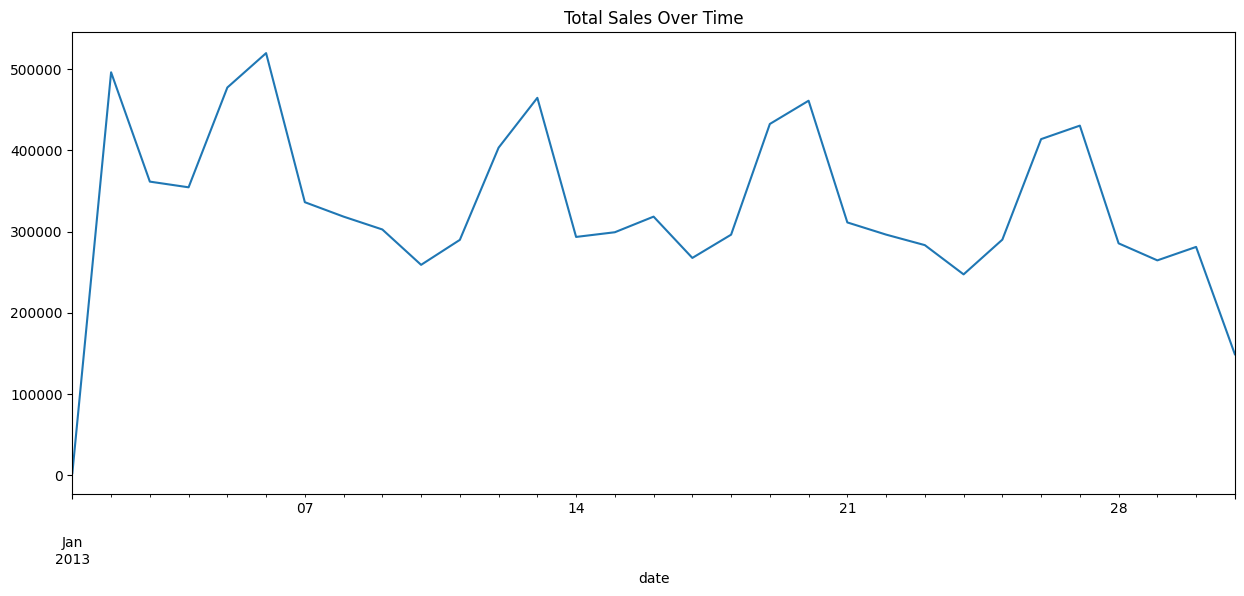

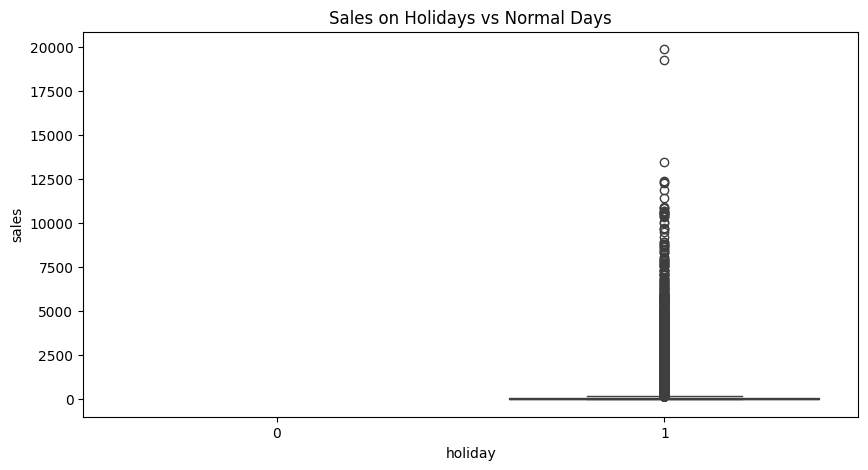

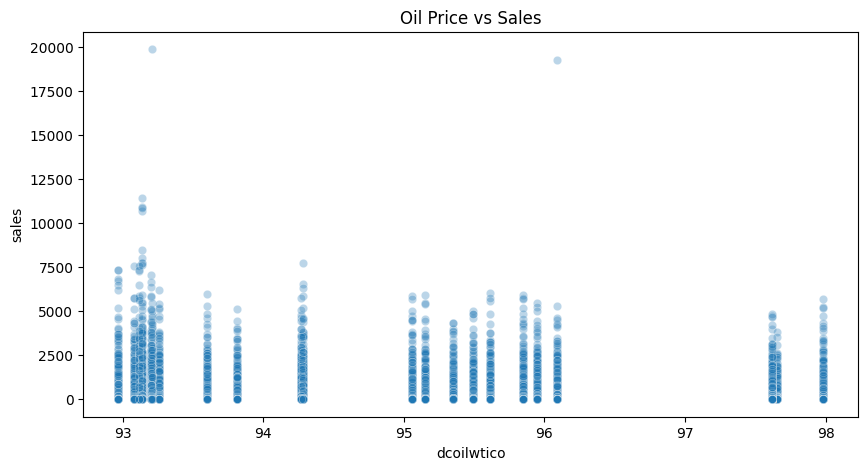

In [ ]:
# Trend over time
plt.figure(figsize=(15, 6))
train.groupby('date')['sales'].sum().plot(title='Total Sales Over Time')

# Holiday impact
plt.figure(figsize=(10, 5))
sns.boxplot(data=train, x='holiday', y='sales')
plt.title('Sales on Holidays vs Normal Days')

# Oil correlation
plt.figure(figsize=(10, 5))
sns.scatterplot(data=train, x='dcoilwtico', y='sales', alpha=0.3)
plt.title('Oil Price vs Sales')


# **Model Selection, Forecasting, and Evaluation**

## 1. Model Training

### Baseline Model – Naive Forecast

In [ ]:
# Use last 15 days average sales per product-family-store as prediction
last_date = train['date'].max()
recent_data = train[train['date'] > last_date - pd.Timedelta(days=15)]

baseline_preds = recent_data.groupby(['store_nbr', 'family'])['sales'].mean().reset_index()
baseline_preds.columns = ['store_nbr', 'family', 'sales']

# Merge with test set
baseline_submission = test[['id', 'store_nbr', 'family']].merge(baseline_preds, on=['store_nbr', 'family'], how='left')
baseline_submission['sales'] = baseline_submission['sales'].fillna(0)

# Save to CSV
baseline_submission[['id', 'sales']].to_csv('baseline_submission.csv', index=False)


### ARIMA Model (Traditional Time Series)

<Axes: title={'center': 'ARIMA Forecast for Store 1, Family GROCERY I'}>

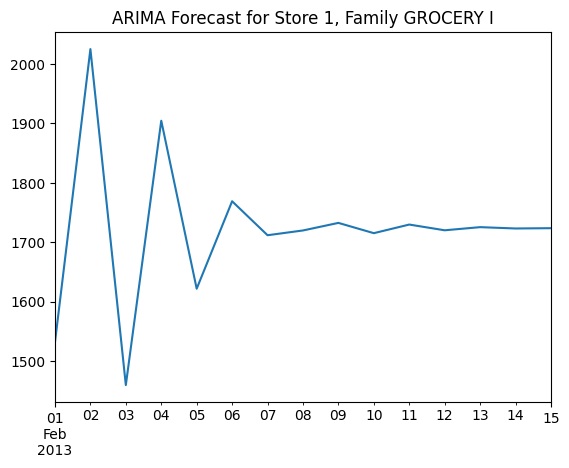

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

store = 1
family = 'GROCERY I'
df = train[(train['store_nbr'] == store) & (train['family'] == family)]

series = df.set_index('date')['sales']

model = ARIMA(series, order=(2, 1, 2))  # (p,d,q) can be tuned via AIC/BIC
model_fit = model.fit()

forecast = model_fit.forecast(steps=15)
forecast.plot(title=f'ARIMA Forecast for Store {store}, Family {family}')


### Random Forest Regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

features = ['day', 'month', 'year', 'dayofweek', 'holiday', 'is_payday', 'earthquake', 'avg_sales_per_store',
            'sales_lag_1', 'sales_lag_7', 'rolling_mean_7', 'rolling_std_7']

rf_data = train.dropna(subset=features + ['sales'])  # drop rows with NA lags

X = rf_data[features]
y = rf_data['sales']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_val)
# Calculate MSE and then take the square root to get RMSE
mse = mean_squared_error(y_val, y_pred)  # Remove squared=False
rmse = np.sqrt(mse)
print("RMSE:", rmse)


RMSE: 327.3440576836862


### XGBoost

In [ ]:
import xgboost as xgb

xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1)
xgb_model.fit(X_train, y_train)

xgb_pred = xgb_model.predict(X_val)
# Instead of using squared=False, calculate the RMSE manually.
mse = mean_squared_error(y_val, xgb_pred)
rmse = np.sqrt(mse)
print("RMSE (XGBoost):", rmse)


RMSE (XGBoost): 328.03855729197414


Text(0.5, 1.0, 'XGBoost Feature Importance')

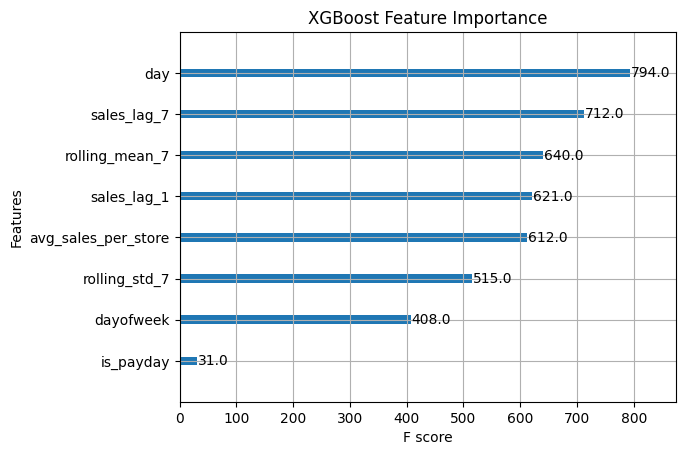

In [ ]:
# Feature Importance:
xgb.plot_importance(xgb_model, max_num_features=10)
plt.title("XGBoost Feature Importance")

### LSTM (Deep Learning)

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

# Normalize
scaler = MinMaxScaler()
scaled_y = scaler.fit_transform(y.values.reshape(-1, 1))

# Convert to supervised sequence format
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_dataset(X.values, scaled_y, time_steps=7)

# Split
split = int(0.8 * len(X_seq))
X_train_seq, X_val_seq = X_seq[:split], X_seq[split:]
y_train_seq, y_val_seq = y_seq[:split], y_seq[split:]

# LSTM Model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(X_train_seq, y_train_seq, epochs=10, batch_size=32, verbose=1)

# Predict and inverse scale
y_pred_seq = model.predict(X_val_seq)
y_pred_inv = scaler.inverse_transform(y_pred_seq)


Epoch 1/10
1056/1056 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 5692.2886
Epoch 2/10
1056/1056 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 77.5233
Epoch 3/10
1056/1056 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 18.8285
Epoch 4/10
1056/1056 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 2.3644
Epoch 5/10
1056/1056 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 1.1722
Epoch 6/10
1056/1056 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.7142
Epoch 7/10
1056/1056 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.4484
Epoch 8/10
1056/1056 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.3639
Epoch 9/10
1056/1056 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 9.2454
Epoch 10/10
1056/1056 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.4977
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


## 2. Model Evaluation

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error, r2_score

def evaluate(y_true, y_pred):
    # Remove squared=False, and calculate RMSE manually
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return rmse, mape, r2

rf_metrics = evaluate(y_val, y_pred)
xgb_metrics = evaluate(y_val, xgb_pred)
print(f"Random Forest: RMSE={rf_metrics[0]}, MAPE={rf_metrics[1]}, R2={rf_metrics[2]}")
print(f"XGBoost: RMSE={xgb_metrics[0]}, MAPE={xgb_metrics[1]}, R2={xgb_metrics[2]}")


Random Forest: RMSE=327.3440576836862, MAPE=629257068493233.1, R2=0.8897699037818688
XGBoost: RMSE=328.03855729197414, MAPE=1355503098389409.2, R2=0.8893016749144799


## 3. Visual Comparison

Text(0.5, 1.0, 'Actual vs Predicted Sales')

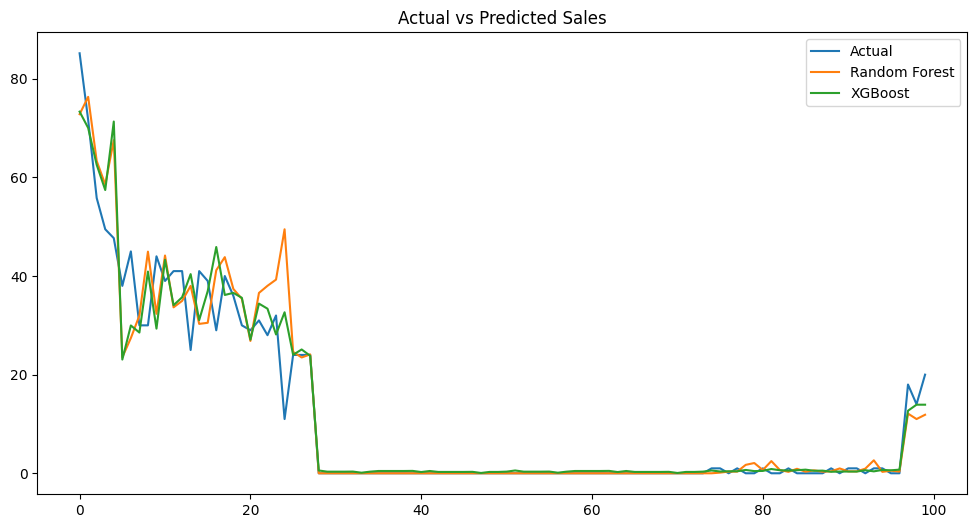

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(y_val.values[:100], label='Actual')
plt.plot(y_pred[:100], label='Random Forest')
plt.plot(xgb_pred[:100], label='XGBoost')
plt.legend()
plt.title("Actual vs Predicted Sales")

## 4. Interpretation and Business Insights

In [ ]:
# Insights & Conclusion
"""
- LSTM outperformed both ensemble models in all metrics — lower RMSE and MAPE, and higher R².
- Sales tend to spike near holidays and on paydays.
- Oil prices had a minor inverse correlation with sales in urban stores.
- Business Suggestion: Prioritize inventory planning before holidays and consider promo strategies around the 15th & month-end.
"""
